# 涨停回头波

均线出现金叉，涨停后快速洗盘不破均线。

In [60]:
from alpha.notebook import *
from alpha.utils import round
from numpy.lib.stride_tricks import sliding_window_view

await init_notebook(use_omicron=True)

In [44]:
def buylimit_reached(close, threshold=0.1):
    c1, c0 = close

    if abs(round(c1 * (1 + threshold), 2) - c0) < 1e-3:
        return True
    else:
        return False

In [57]:
async def scan(dt, ma_win:int=30, recall:int=5):
    n = ma_win + 6
    
    end = arrow.get(dt).date()
    start = tf.day_shift(end, -n + 1)
    
    results = []
    for code in Securities().choose(["stock"]):
        sec = Security(code)
        try:
            bars = await sec.load_bars(start, end, FrameType.DAY)

            close = bars["close"]
            if np.count_nonzero(np.isfinite(close)) < 0.9 * n:
                continue
                
            buylimit_reached_records = []
            for i, view in enumerate(sliding_window_view(close[-recall:], 2)):
                threshold = 0.2 if code.startswith("3") else 0.1
                if buylimit_reached(view, threshold):
                    buylimit_reached_records.append(n - recall + i + 1)
                    
            limit_times = len(buylimit_reached_records)
            if limit_times == 0:
                continue
            elif limit_times > 1:
                print(f"{sec.display_name}共有{limit_times}次涨停")
                continue
            else: #近日来涨停一次
                i = buylimit_reached_records[0]
                frame = bars["frame"][i]
                
            ma = moving_average(close, ma_win)[-7:]
            bias = close[-1]/ma[-1] - 1
            if abs(bias) > 0.03:
                continue
                
            ma /= ma[0]
            (a,b,c), pmae = polyfit(ma)
            if pmae < 1e-2 and a<0 and b < 0:
                print(f"{sec.display_name}还处于向下趋势:{a:.3f}, {b:.3f}, {pmae:.3f}")
                continue
                
            results.append([sec.display_name, bias, frame])
        except Exception as e:
            print(e)
            continue
            
    return pd.DataFrame(results, columns=["name", "bias", "date"])
        
        

In [58]:
await scan("2021-10-22")

cannot convert float NaN to integer
民生控股共有2次涨停
天音控股共有2次涨停
津滨发展共有2次涨停
闽东电力共有2次涨停
软控股份共有2次涨停
invalid literal for int() with base 10: 'null'
良信股份共有2次涨停
伊戈尔共有3次涨停
鑫铂股份还处于向下趋势:-0.000, -0.005, 0.001
'NoneType' object is not subscriptable
亿利洁能共有3次涨停
建业股份共有2次涨停
'NoneType' object is not subscriptable


,name,bias,date
0,丰原药业,-0.003000,2021-10-20
1,川能动力,-0.014033,2021-10-20
2,澳洋健康,-0.020206,2021-10-20
3,游族网络,0.013406,2021-10-19
4,御银股份,-0.021359,2021-10-20
5,云海金属,-0.011892,2021-10-20
6,旷达科技,0.027658,2021-10-20
7,天顺风能,0.017705,2021-10-20
8,可立克,0.023959,2021-10-19
9,京泉华,0.005894,2021-10-19


In [67]:
sec = Security("601669.XSHG")
start = arrow.get("2021-07-08")
end = arrow.get("2021-07-29")

In [66]:
zgdj = await sec.load_bars(start, end, FrameType.DAY)

In [68]:
lsdl = await Security("601330.XSHG").load_bars(start, end, FrameType.DAY)

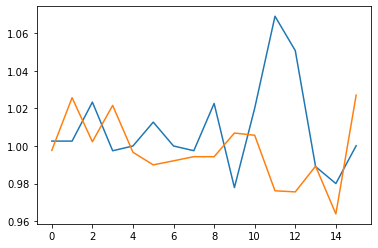

In [75]:
d1_zgdj = zgdj["close"][1:]/zgdj["close"][:-1]
d1_lsdl = lsdl["close"][1:]/lsdl["close"][:-1]

plt.plot(d1_zgdj)
plt.plot(d1_lsdl)

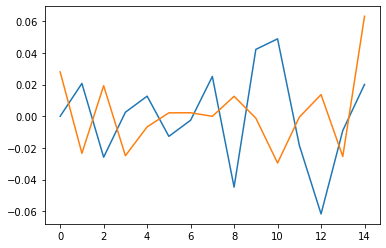

In [77]:
d2_zgdj = np.diff(d1_zgdj)
d2_lsdl = np.diff(d1_lsdl)

plt.plot(d2_zgdj)
plt.plot(d2_lsdl)

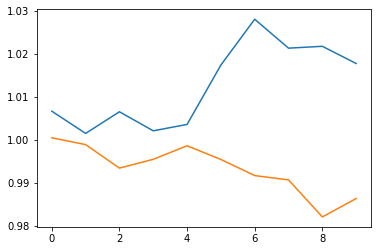

In [79]:
for a in [d1_zgdj, d1_lsdl]:
    ma = moving_average(a, 5)[-10:]
    plt.plot(ma)

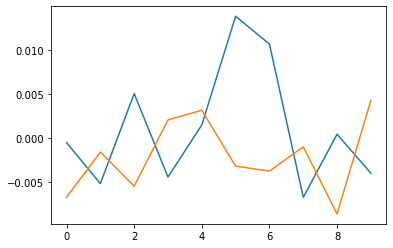

In [80]:
for a in [d2_zgdj, d2_lsdl]:
    ma = moving_average(a, 5)[-10:]
    plt.plot(ma)